https://somjang.tistory.com/entry/Keras%EA%B8%B0%EC%82%AC-%EC%A0%9C%EB%AA%A9%EC%9D%84-%EA%B0%80%EC%A7%80%EA%B3%A0-%EA%B8%8D%EC%A0%95-%EB%B6%80%EC%A0%95-%EC%A4%91%EB%A6%BD-%EB%B6%84%EB%A5%98%ED%95%98%EB%8A%94-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EC%96%B4%EB%B3%B4%EA%B8%B0

참고

In [ ]:
# 라이브러리 및 경로 설정
!pip install konlpy
import konlpy
from konlpy.tag import Okt
import pandas as pd
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

DATASET_PATH = config.PATH_CONFIG['DATASET_PATH']
RESULT_PATH = config.PATH_CONFIG['RESULT_PATH']
TRAIN_DATA_FILE = config.PATH_CONFIG['TRAIN_DATA_FILE']
TEST_DATA_FILE = config.PATH_CONFIG['TEST_DATA_FILE']
STOP_WORDS_FILE = config.PATH_CONFIG['STOP_WORDS_FILE']


In [ ]:
# stop word 사전 구축
f = open(DATASET_PATH + STOP_WORDS_FILE,'r')
stop_words = []
while True:
    line = f.readline()
    if not line: break
    stop_words.append(line[:-1])


In [ ]:
# text 형태소 단위로 분리
train_data = pd.read_excel(DATASET_PATH + TRAIN_DATA_FILE)
test_data = pd.read_excel(DATASET_PATH + TEST_DATA_FILE)

okt = Okt()
x_train = []
for sentence in train_data['sentence']:
  temp_x = []
  temp_x = okt.morphs(sentence, stem = True)
  temp_x = [word for word in temp_x if not word in stop_words]
  x_train.append(temp_x)

x_test = []
for sentence in test_data['sentence']:
  tmp = []
  tmp = okt.morphs(sentence, stem = True)
  tmp = [word for word in tmp if not word in stop_words]
  x_test.append(tmp)



In [ ]:
print(x_train[:3])

[['화가', '난', '다화', '화가', '난', '다'], ['그린', '라이트', '인가요'], ['여자친구', '랑', '헤어지다', '요', '?']]


In [ ]:
print(x_test[:3])

[['현우진', '그렇게', '좋다', '다해', '서', '인강'], ['짜증', '요'], ['슬프다', '속상하다', '면', '가정폭력']]


In [ ]:
# 단어 토큰화
max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
print(x_train[:3])
print(x_test[:3])

[[111, 340, 2822, 111, 340, 87], [1106, 1872, 56], [131, 104, 186, 12, 7]]
[[1271, 5, 134, 84, 2136], [26, 12], [2, 10, 129, 2462]]


In [ ]:
# 라벨 원핫인코딩
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
enc = OneHotEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train).toarray()
y_test = enc.transform(y_test).toarray()

In [ ]:
# sentence 데이터에 패딩 추가하여 길이 맞춰주기
max_len = 20
x_train = pad_sequences(x_train, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)

In [ ]:
#학습 진행
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(LSTM(128))
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 10, validation_split=0.1)

Epoch 1/10
972/972 [==============================] - 36s 37ms/step - loss: 0.4149 - accuracy: 0.8535 - val_loss: 0.1910 - val_accuracy: 0.9352
Epoch 2/10
972/972 [==============================] - 36s 37ms/step - loss: 0.1606 - accuracy: 0.9463 - val_loss: 0.1973 - val_accuracy: 0.9315
Epoch 3/10
972/972 [==============================] - 37s 38ms/step - loss: 0.1360 - accuracy: 0.9597 - val_loss: 0.2016 - val_accuracy: 0.9408
Epoch 4/10
972/972 [==============================] - 38s 39ms/step - loss: 0.1221 - accuracy: 0.9629 - val_loss: 0.1871 - val_accuracy: 0.9454
Epoch 5/10
972/972 [==============================] - 40s 41ms/step - loss: 0.1125 - accuracy: 0.9669 - val_loss: 0.1914 - val_accuracy: 0.9445
Epoch 6/10
972/972 [==============================] - 37s 38ms/step - loss: 0.0972 - accuracy: 0.9715 - val_loss: 0.2091 - val_accuracy: 0.9399
Epoch 7/10
972/972 [==============================] - 43s 45ms/step - loss: 0.0908 - accuracy: 0.9736 - val_loss: 0.2109 - val_accuracy:

In [ ]:
print("테스트 정확도 : {:.2f}%".format(model.evaluate(x_test, y_test)[1]))

167/167 [==============================] - 1s 8ms/step - loss: 0.2257 - accuracy: 0.9449
테스트 정확도 : 0.94%


In [ ]:
# 예측 결과 비교
sentiment_dict = {0: '기쁨', 1: '슬픔', 2: '우울', 3: '설렘', 4: '화남'}
predict = model.predict(x_test)
predict_labels = np.argmax(predict, axis = 1)
original_labels = np.argmax(y_test, axis = 1)
for i in range(30):
  print(test_data['sentence'].iloc[i]) 
  print(">> 원래 :",sentiment_dict[original_labels[i]], "/ 예측 결과 :",sentiment_dict[predict_labels[i]])

제가 현우진이 그렇게 좋다해서 인강을
>> 원래 : 기쁨 / 예측 결과 : 기쁨
요즘 자꾸 짜증이나요
>> 원래 : 화남 / 예측 결과 : 화남
정말 슬프고 속상한 예를들면 가정폭력
>> 원래 : 슬픔 / 예측 결과 : 슬픔
띄어쓰기랑 틀린 곳 좀 바르게 ..
>> 원래 : 우울 / 예측 결과 : 기쁨
똥 누기전에 기분좋은 이유
>> 원래 : 기쁨 / 예측 결과 : 기쁨
좋다 좋다의 영어단어 좀 알려주세요,,
>> 원래 : 기쁨 / 예측 결과 : 기쁨
메이플스토리 두심
>> 원래 : 설렘 / 예측 결과 : 설렘
좋아하는 여자에게 친해지는 방법은?
>> 원래 : 설렘 / 예측 결과 : 설렘
ㅅㅂ 얘네 어케 싸워요 빡치네 스위치
>> 원래 : 화남 / 예측 결과 : 화남
친구가 짜증나여...
>> 원래 : 화남 / 예측 결과 : 화남
떨어져 속상한데 어떻게 진행하는게... 
>> 원래 : 슬픔 / 예측 결과 : 슬픔
요즘 자꾸 짜증이 나요...
>> 원래 : 화남 / 예측 결과 : 화남
저가사랑에빠진거같아요
>> 원래 : 설렘 / 예측 결과 : 설렘
궁합이 좋다그러는데 정말그런가요?
>> 원래 : 기쁨 / 예측 결과 : 기쁨
좋아하는여자를 사랑하는이유 10가지
>> 원래 : 설렘 / 예측 결과 : 설렘
jtint01 님 즐거운 주말이네요.
>> 원래 : 기쁨 / 예측 결과 : 기쁨
모든것을 알게되니까 너무 허무해요
>> 원래 : 우울 / 예측 결과 : 우울
굶어서 살빼면 좋다?
>> 원래 : 기쁨 / 예측 결과 : 기쁨
사랑니 충치인가요ㅠ 너무 슬프고... 
>> 원래 : 슬픔 / 예측 결과 : 슬픔
상계중가는데 .ㅅㅂ
>> 원래 : 화남 / 예측 결과 : 화남
내가 좋아하는 사람을 만나야 할까요,
>> 원래 : 설렘 / 예측 결과 : 설렘
동성끼리 사랑하는 사람들은 왜... 
>> 원래 : 설렘 / 예측 결과 : 설렘
가족들때문에 속상해요
>> 원래 : 슬픔 / 예측 결과 : 슬픔
행복하신가요??
>> 원래 : 기쁨 / 예측 결과 : 기쁨
아무 이유 없이 슬플때

In [ ]:
# tokenizer와 model 저장

import pickle

# saving tokenizer 
with open(RESULT_PATH + 'lstm_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save(RESULT_PATH + 'lstm_model.h5')

In [ ]:
# 샘플 데이터로 테스트
pred = []
sample_data = "나 기분이 너무 좋아"
temp_x = okt.morphs(sample_data, stem = True)
temp_x = [word for word in temp_x if not word in stop_words]
pred.append(temp_x)
tokenizer.fit_on_texts(pred)
pred = tokenizer.texts_to_sequences(pred)
pad_sequences(pred, maxlen = max_len)
predict = model.predict(pred)
print('"'+sample_data+'"'+"로 추측한 라벨 :",sentiment_dict[np.argmax(predict, axis = 1)[0]])
print("class별로 확률(기쁨(0) 슬픔(1) 우울(2) 설렘(3) 화남(4))")
predict

"나 기분이 너무 좋아"로 추측한 라벨 : 기쁨
class별로 확률(기쁨(0) 슬픔(1) 우울(2) 설렘(3) 화남(4))


array([[9.9261439e-01, 2.2858069e-03, 4.5562298e-03, 5.2361673e-04,
        2.0055862e-05]], dtype=float32)

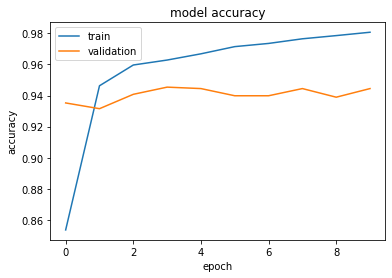

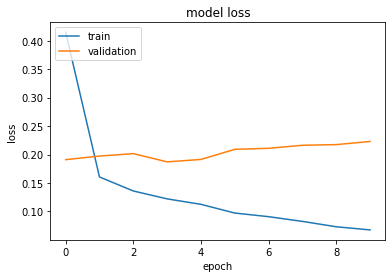

In [ ]:
# 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(RESULT_PATH + 'lstm_acc.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(RESULT_PATH + 'lstm_loss.png')
plt.show()